### papers
- [Mask R-CNN](https://arxiv.org/pdf/1703.06870.pdf)
- [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf)
- [FPN](https://arxiv.org/pdf/1612.03144.pdf)

### some code is taken from 
- https://colab.research.google.com/github/pytorch/vision/blob/temp-tutorial/tutorials/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=cFHKCvCTxiff

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import torch
# import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchviz import make_dot, make_dot_from_trace

import numpy as np
import torch.utils.data
from PIL import Image

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:

# import cs236781.plot as plot
import myutils.download

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
DATA_URL = 'https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip'

_, dataset_dir = myutils.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File C:\Users\Noam\.pytorch-datasets\PennFudanPed.zip exists, skipping download.
Extracting C:\Users\Noam\.pytorch-datasets\PennFudanPed.zip...
Extracted 516 to C:\Users\Noam\.pytorch-datasets\PennFudanPed


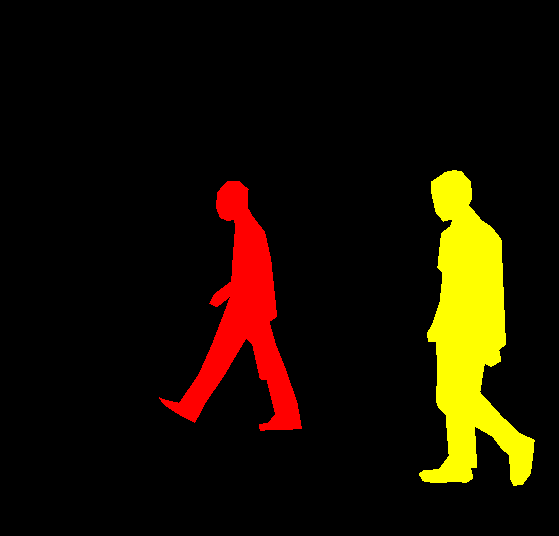

In [3]:
from PIL import Image
img = DATA_DIR.joinpath('PennFudanPed/PNGImages/FudanPed00001.png')
msk = DATA_DIR.joinpath('PennFudanPed/PedMasks/FudanPed00001_mask.png')

# Image.open(x)
mask = Image.open(msk)
# mask

# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask


In [9]:
from dataset import PennFudanDataset
import torchvision.transforms as T

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
#     T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
#     T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds = PennFudanDataset(dataset_dir,  tf)

In [10]:
ds[0]

(tensor([[[0.8275, 0.8235, 0.8314,  ..., 0.5608, 0.5725, 0.5804],
          [0.7020, 0.6784, 0.6667,  ..., 0.4941, 0.5020, 0.5020],
          [0.8000, 0.7608, 0.7373,  ..., 0.5098, 0.5137, 0.5098],
          ...,
          [0.8863, 0.8510, 0.8275,  ..., 0.7176, 0.7216, 0.7255],
          [0.9059, 0.8588, 0.8235,  ..., 0.7333, 0.7333, 0.7294],
          [0.8824, 0.8902, 0.8431,  ..., 0.7451, 0.7451, 0.7333]],
 
         [[0.7843, 0.7804, 0.7882,  ..., 0.3765, 0.3882, 0.3961],
          [0.6588, 0.6353, 0.6235,  ..., 0.3098, 0.3176, 0.3176],
          [0.7569, 0.7176, 0.6941,  ..., 0.3255, 0.3294, 0.3255],
          ...,
          [0.8627, 0.8275, 0.8039,  ..., 0.7176, 0.7216, 0.7255],
          [0.8824, 0.8353, 0.8000,  ..., 0.7333, 0.7333, 0.7294],
          [0.8588, 0.8667, 0.8196,  ..., 0.7451, 0.7451, 0.7333]],
 
         [[0.7137, 0.7098, 0.7176,  ..., 0.3059, 0.3176, 0.3255],
          [0.5882, 0.5647, 0.5529,  ..., 0.2392, 0.2471, 0.2471],
          [0.6863, 0.6471, 0.6235,  ...,

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

In [12]:
model = model.to(device)

In [13]:
# pick one image from the test set
img, _ = ds[5]
# img = T.ToTensor()(img)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [14]:
prediction

[{'boxes': tensor([[200.8228, 102.8869, 344.0872, 389.5976],
          [  0.3928, 102.5694,  87.5657, 387.5129],
          [ 32.8720,  93.4753,  86.6027, 263.9992],
          [315.8396, 145.0643, 358.7343, 271.5006],
          [278.0840,  86.0722, 350.8476, 375.8281],
          [270.6968,  83.8962, 343.9194, 222.0517],
          [ 35.8494,  91.0773, 101.9489, 376.9044],
          [ 38.0811, 255.5033,  91.5241, 306.8584],
          [ 37.2504, 258.4817,  92.3723, 306.7461],
          [282.0231, 132.0805, 359.6061, 266.7517],
          [320.4123, 196.3405, 356.3678, 272.3007],
          [232.5402,  96.9286, 342.5029, 252.1827],
          [  0.0000, 106.6746,  57.3338, 297.0607],
          [  6.5588, 204.9950,  32.9989, 254.1014],
          [281.5530, 256.5345, 353.2495, 357.4832],
          [277.4929, 125.1131, 358.2079, 256.8378],
          [ 45.4692,   0.0000, 229.2567, 217.0795],
          [321.2491, 218.8710, 355.8583, 273.3246],
          [213.0372, 241.0221, 346.4377, 375.6495],
   

In [15]:
from torchvision.utils import make_grid
from PIL import Image, ImageDraw

def draw_bbox(tensor, bboxes, fill=None, outline=None, width=1,):    
    im = T.ToPILImage()(tensor.cpu())
    for bbox in bboxes.cpu():
        ImageDraw.Draw(im).rectangle(np.array(bbox), fill=fill, outline=outline, width=width)
    return im

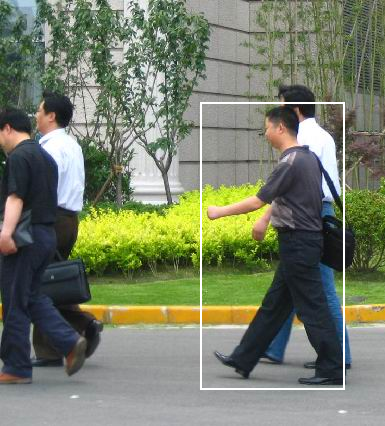

In [39]:
bbox = prediction[0]['boxes'][:1]
draw_bbox(img, bbox, width=2)

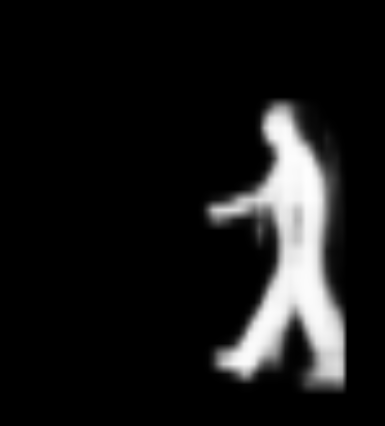

In [43]:
mask = prediction[0]['masks'][0,:,:,:]
T.ToPILImage()(mask.cpu())